In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo

sns.set_theme()

## Self-Organizing Novelty Detector (SONDE)

It operates by incrementally learning patterns and identifying unexpected events in dynamic environments. Is a unsupervised and adaptative method with a algorithmic complexity $O(n^2)$.

Based on two strategies:

- GWR: Grow When Required
- SOM: Self-Organizing Maps

Main parameters:

- $\alpha$: Changes the cluster centroid
- $\sigma$: Controls the Gaussian spread
- $\beta$: Sigma adaptation for each specific cluster

In the context of __Markov Chains__ each cluster defined by a Gaussian represents one possible state on the chain.

In [2]:
data = np.array(
    [
        [5, 5],
        [5.2, 4.8],
        [4.7, 5.3],
        [10, 10],
        [10.2, 9.8],
        [9.7, 10.3],
        [5, 5],
    ]
)
data

array([[ 5. ,  5. ],
       [ 5.2,  4.8],
       [ 4.7,  5.3],
       [10. , 10. ],
       [10.2,  9.8],
       [ 9.7, 10.3],
       [ 5. ,  5. ]])

In [3]:
def get_closest_gaussian(example, centroids, sigma, threshold=1e-3):
    """Find the closest Gaussian cluster from the example point. If no clusters
    have been created the function return -1."""
    # check if there is no centroids
    if centroids.size == 0:
        return -1

    euclidian_distance = np.apply_along_axis(
        lambda center: (np.sum((center - example) ** 2)) ** (1 / 2),
        1,
        centroids,
    )
    activation = np.exp(-(euclidian_distance**2) / (2 * sigma**2))
    idx = activation.argmax()

    # manages the sensitivity for new clusters creation
    if activation[idx] < threshold:
        return -1
    return idx


def estimate_markov_chain_entropy_rate(adj_mat: np.array) -> float:
    """Calculates the Shannon entropy for a Markov Chain given your
    adjacency matrix representation."""
    return -1 * np.sum(adj_mat * np.log2(adj_mat))


def sonde(X, alpha=0.01, sigma=1, eps=1e-7, delta=0.01, verbose=True):
    d = X.shape[1]
    centroids = np.empty((0, d))
    old_pos = -1
    curr_pos = -1
    markov = None
    old_H = -1
    curr_H = -1
    H = []
    delta_H = []

    for point in X:
        example = point.reshape(1, d)
        curr_pos = get_closest_gaussian(example, centroids, sigma)

        if curr_pos == -1:
            # create a new Gaussian
            if centroids.size == 0:
                centroids = np.concatenate((centroids, example), axis=0)
                curr_pos = 0
                markov = np.array([[eps]])
            else:
                centroids = np.concatenate((centroids, example), axis=0)
                curr_pos = centroids.shape[0] - 1

            if centroids.shape[0] > 1:
                markov = np.pad(
                    markov,
                    ((0, 1), (0, 1)),
                    mode="constant",
                    constant_values=eps,
                )
        else:
            # adapt an existing Gaussian
            centroids[curr_pos, :] = (1 - alpha) * centroids[
                curr_pos, :
            ] + alpha * example

        if old_pos != -1:
            markov[old_pos, curr_pos] = markov[old_pos, curr_pos] + delta
            if verbose:
                print(f"Moved from state ( {old_pos} ) to ( {curr_pos} )")

        # normalize the adjacency matrix
        for i in range(markov.shape[0]):
            markov[i] = markov[i, :] / sum(markov[i, :])

        # calculate the entropy
        curr_H = estimate_markov_chain_entropy_rate(markov)
        H.append(curr_H)

        # calculate the entropy difference
        if old_H != -1:
            delta_H.append(curr_H - old_H)

        if verbose:
            print(f"Markov Adjacency Matrix:\n{markov}")
            print("-" * 50)

        old_pos = curr_pos
        old_H = curr_H

    return delta_H, H, centroids, markov

In [4]:
dH, H, centroids, markov = sonde(X=data, verbose=True)

Markov Adjacency Matrix:
[[1.]]
--------------------------------------------------
Moved from state ( 0 ) to ( 0 )
Markov Adjacency Matrix:
[[1.]]
--------------------------------------------------
Moved from state ( 0 ) to ( 0 )
Markov Adjacency Matrix:
[[1.]]
--------------------------------------------------
Moved from state ( 0 ) to ( 1 )
Markov Adjacency Matrix:
[[0.99009891 0.00990109]
 [0.5        0.5       ]]
--------------------------------------------------
Moved from state ( 1 ) to ( 1 )
Markov Adjacency Matrix:
[[0.99009891 0.00990109]
 [0.4950495  0.5049505 ]]
--------------------------------------------------
Moved from state ( 1 ) to ( 1 )
Markov Adjacency Matrix:
[[0.99009891 0.00990109]
 [0.49014802 0.50985198]]
--------------------------------------------------
Moved from state ( 1 ) to ( 0 )
Markov Adjacency Matrix:
[[0.99009891 0.00990109]
 [0.49519606 0.50480394]]
--------------------------------------------------


In [5]:
centroids

array([[ 4.9989902,  5.0010098],
       [ 9.99898  , 10.00102  ]])

## Time Series Data Example

In [6]:
# fetch dataset
toy_data = fetch_ucirepo(id=849)
toy_data = pd.DataFrame(
    toy_data.data.targets["Zone 1 Power Consumption"]
).values

In [7]:
dH, H, centroids, markov = sonde(
    X=toy_data, verbose=False, sigma=1000, delta=0.08
)

In [8]:
print(
    f"Total Number of Gaussians: {len(centroids)}\n\nCentroids:\n\n{centroids}"
)

Total Number of Gaussians: 11

Centroids:

[[33312.57309826]
 [30891.4939403 ]
 [28318.79031478]
 [25022.61994598]
 [36808.20341654]
 [39446.49818873]
 [22225.51194093]
 [13963.59379581]
 [44080.06259361]
 [46417.1414591 ]
 [20081.03920279]]


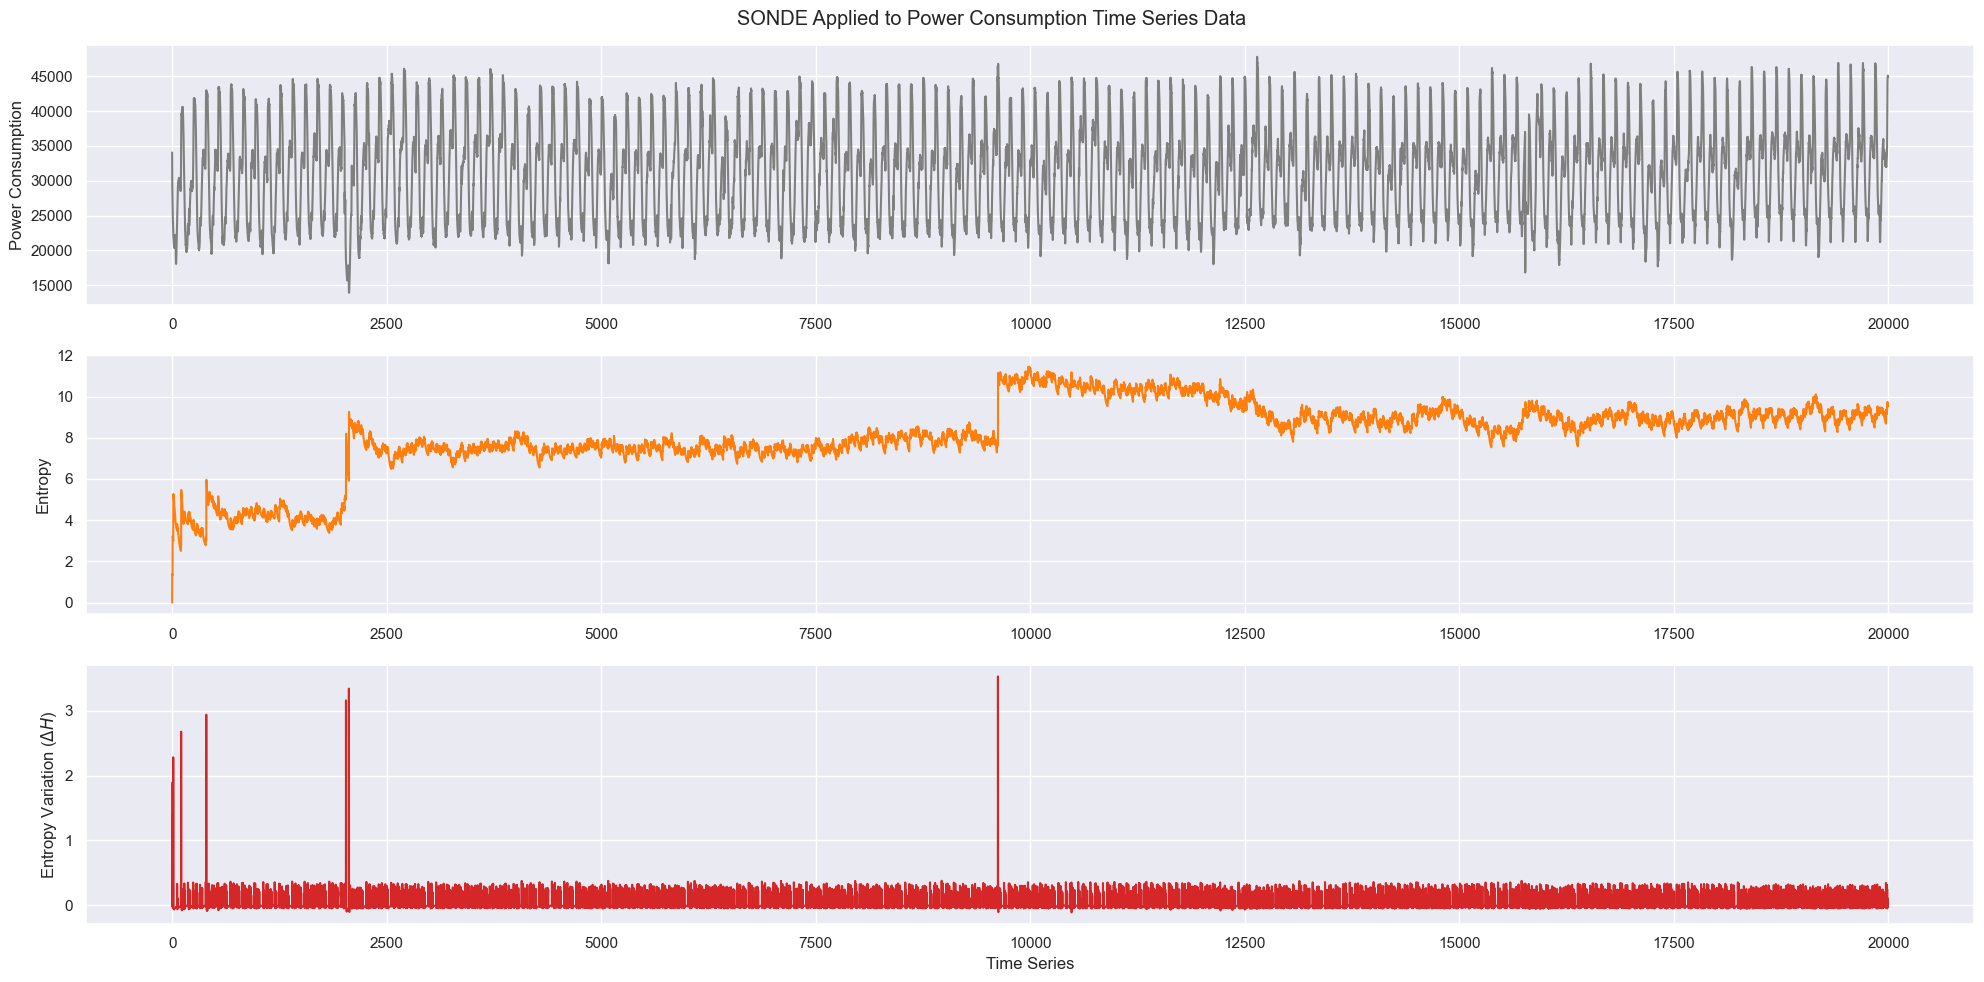

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(20, 10))
fig.suptitle("SONDE Applied to Power Consumption Time Series Data")
ax1.plot(toy_data[:20000, :], "tab:gray")
ax2.plot(H[:20000], "tab:orange")
ax3.plot(dH[:20000], "tab:red")
ax1.set_ylabel("Power Consumption")
ax2.set_ylabel("Entropy")
ax3.set_ylabel(r"Entropy Variation ($\Delta H$)")
ax3.set_xlabel("Time Series")
fig.tight_layout();